<a href="https://www.kaggle.com/code/tinatally/bbc-news-classification?scriptVersionId=259393256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%matplotlib inline
import  matplotlib.pyplot as plt
plt.style.use("ggplot")

from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords 
nltk.download('stopwords')

#Topic modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
#train data
train_df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
#Test data
test_df = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
def summary_info(df):
    print("INFO")
    display(df.info())
    print("Summary information")
    display(df.describe())
    print("Null Values")
    null_values = df.isnull().sum()/df.shape[0]
    display(null_values[null_values >0])
    print('Duplicate Articles')
    display(df.duplicated().sum())

summary_info(train_df)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


None

Summary information


,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


Null Values


Series([], dtype: float64)

Duplicate Articles


0

## EDA

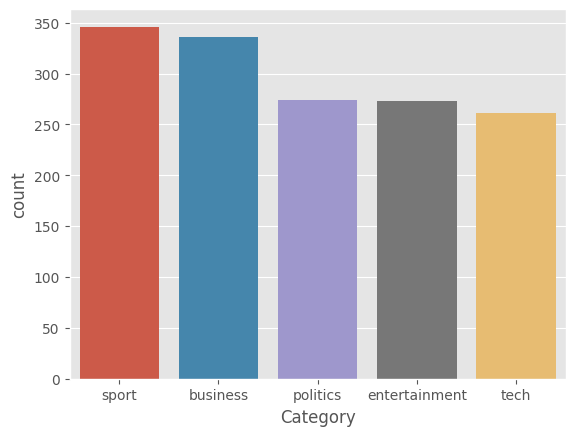

In [4]:
order_values = train_df['Category'].value_counts().index
sns.countplot(train_df, x='Category', order = order_values);

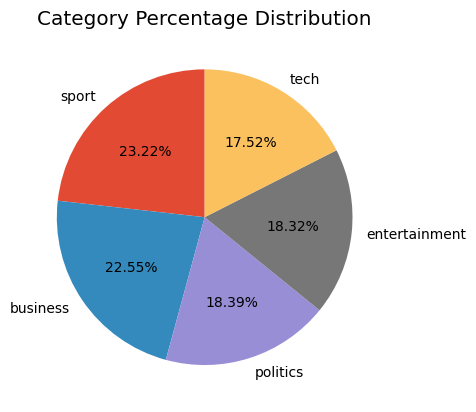

In [5]:
#compute percentage distribution of category values 
cat_count = (train_df['Category'].value_counts()/train_df.shape[0]*100).round(2)
cat_per = cat_count[order_values]
plt.pie(cat_per, labels=cat_per.index, autopct='%1.2f%%', startangle=90);
plt.title("Category Percentage Distribution");

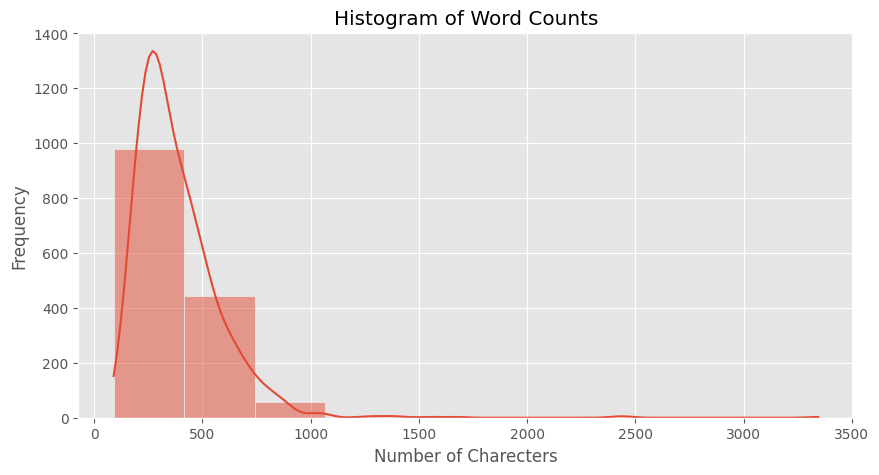

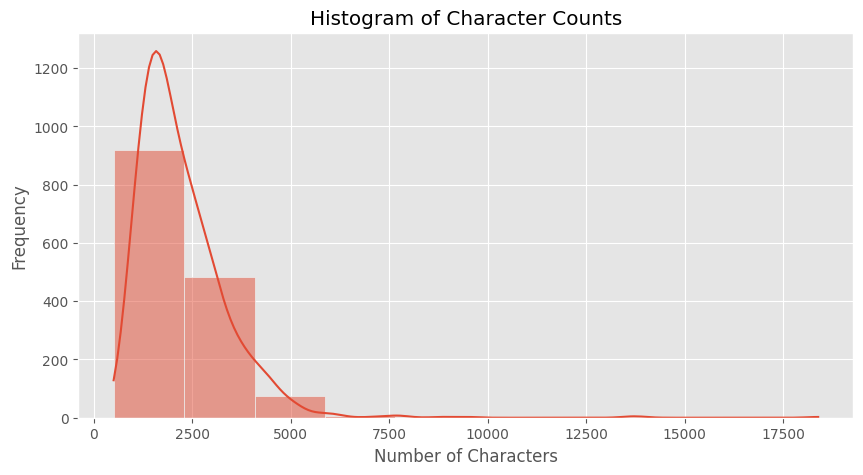

In [6]:
# check word count in text
train_df['word_count'] = train_df['Text'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['Text'].apply(lambda x: len(str(x)))

#Histogram of word counts
plt.figure(figsize = (10,5));
sns.histplot(train_df['word_count'],bins=10,kde=True);
plt.title('Histogram of Word Counts');
plt.xlabel('Number of Charecters');
plt.ylabel('Frequency');


#Histogram of Character Counts
plt.figure(figsize=(10,5));
sns.histplot(train_df['char_count'], bins=10,kde=True);
plt.title('Histogram of Character Counts');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');


### Skewness and Matrix Factorization
Since most articles are short but a few are very long, the distributions of word and character counts are right-skewed. When applying Matrix Factorization, this can cause rows in the document–term matrix with very large total counts to dominate the learning of latent factors. To mitigate this, I could either:

- Normalize inputs (e.g., use TF-IDF instead of raw counts).

- Apply log-scaling to reduce the influence of extreme document lengths.

This way, MF can focus on learning latent semantic structures rather than just distinguishing between long and short articles.


In [7]:
#Average and mean lengths per category
length_stats = train_df.groupby('Category').agg(
    avg_words = ('word_count', 'mean'),
    median_words = ("word_count", 'median'),
    avg_chars = ('char_count', 'mean'),
    median_chars = ('char_count', 'median')
).round(2)

length_stats

,avg_words,median_words,avg_chars,median_chars
Category,,,,
business,334.17,304.0,1983.10,1830.5
entertainment,333.91,272.0,1910.38,1571.0
politics,449.69,441.5,2617.91,2599.5
sport,335.35,294.5,1894.62,1641.0
tech,501.86,457.0,2939.29,2657.0


The results show that Politics & Tech articles are much longer on average, possibly because they require more explanation, detail, or technical analysis.

Entertainment articles on the other hand are shorter and more varied, lots of short pieces (movie releases, gossip, etc.) but also occasional long features.

Median vs. Average helps spot skewness:

Business & Entertainment: skewed (outliers pulling the average up).

Politics & Tech: less skewed (distributions are more symmetric).

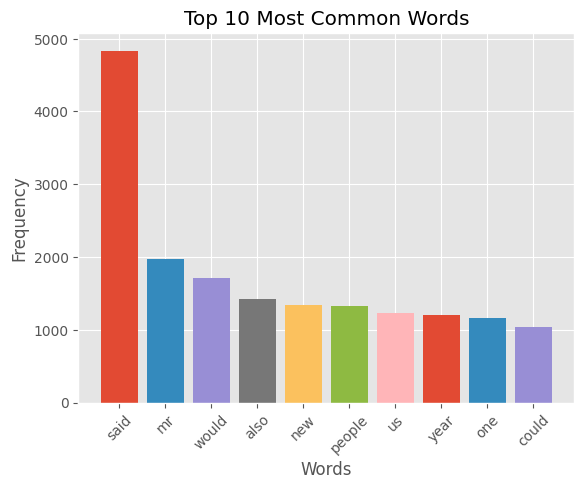

In [8]:
stop_words = set(stopwords.words('english'))

#function to tokenize and remove stopwords
def tokenize_text(text):
    words = str(text).lower().split()
    words = [w.strip('.,!?;:()[]-"\'%£') for w in words]
    return [w for w in words  if w not in stop_words and w != '']
    
#Most common words 
all_words = []
train_df['Text'].apply(lambda x: all_words.extend(tokenize_text(x)))
overall_counts = Counter(all_words)
top10_words = dict(overall_counts.most_common(10))
for word, count in top10_words.items():
    # print(f'{word}: {count}')
    plt.bar(word,count)
    plt.title("Top 10 Most Common Words")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45);

#Most common words and Vocabulary per category
vocab_per_category = {}
category_counts = {}
for cat, group in train_df.groupby('Category'):
    words_cat = []
    group['Text'].apply(lambda x: words_cat.extend(tokenize_text(x)))
    category_counts[cat] = Counter(words_cat).most_common(10)
    vocab_per_category[cat] = len(set(words_cat))
    
vocab = pd.DataFrame({
    'Cetegory': list(vocab_per_category.keys()),
    'Vocabary_size': list(vocab_per_category.values())
})



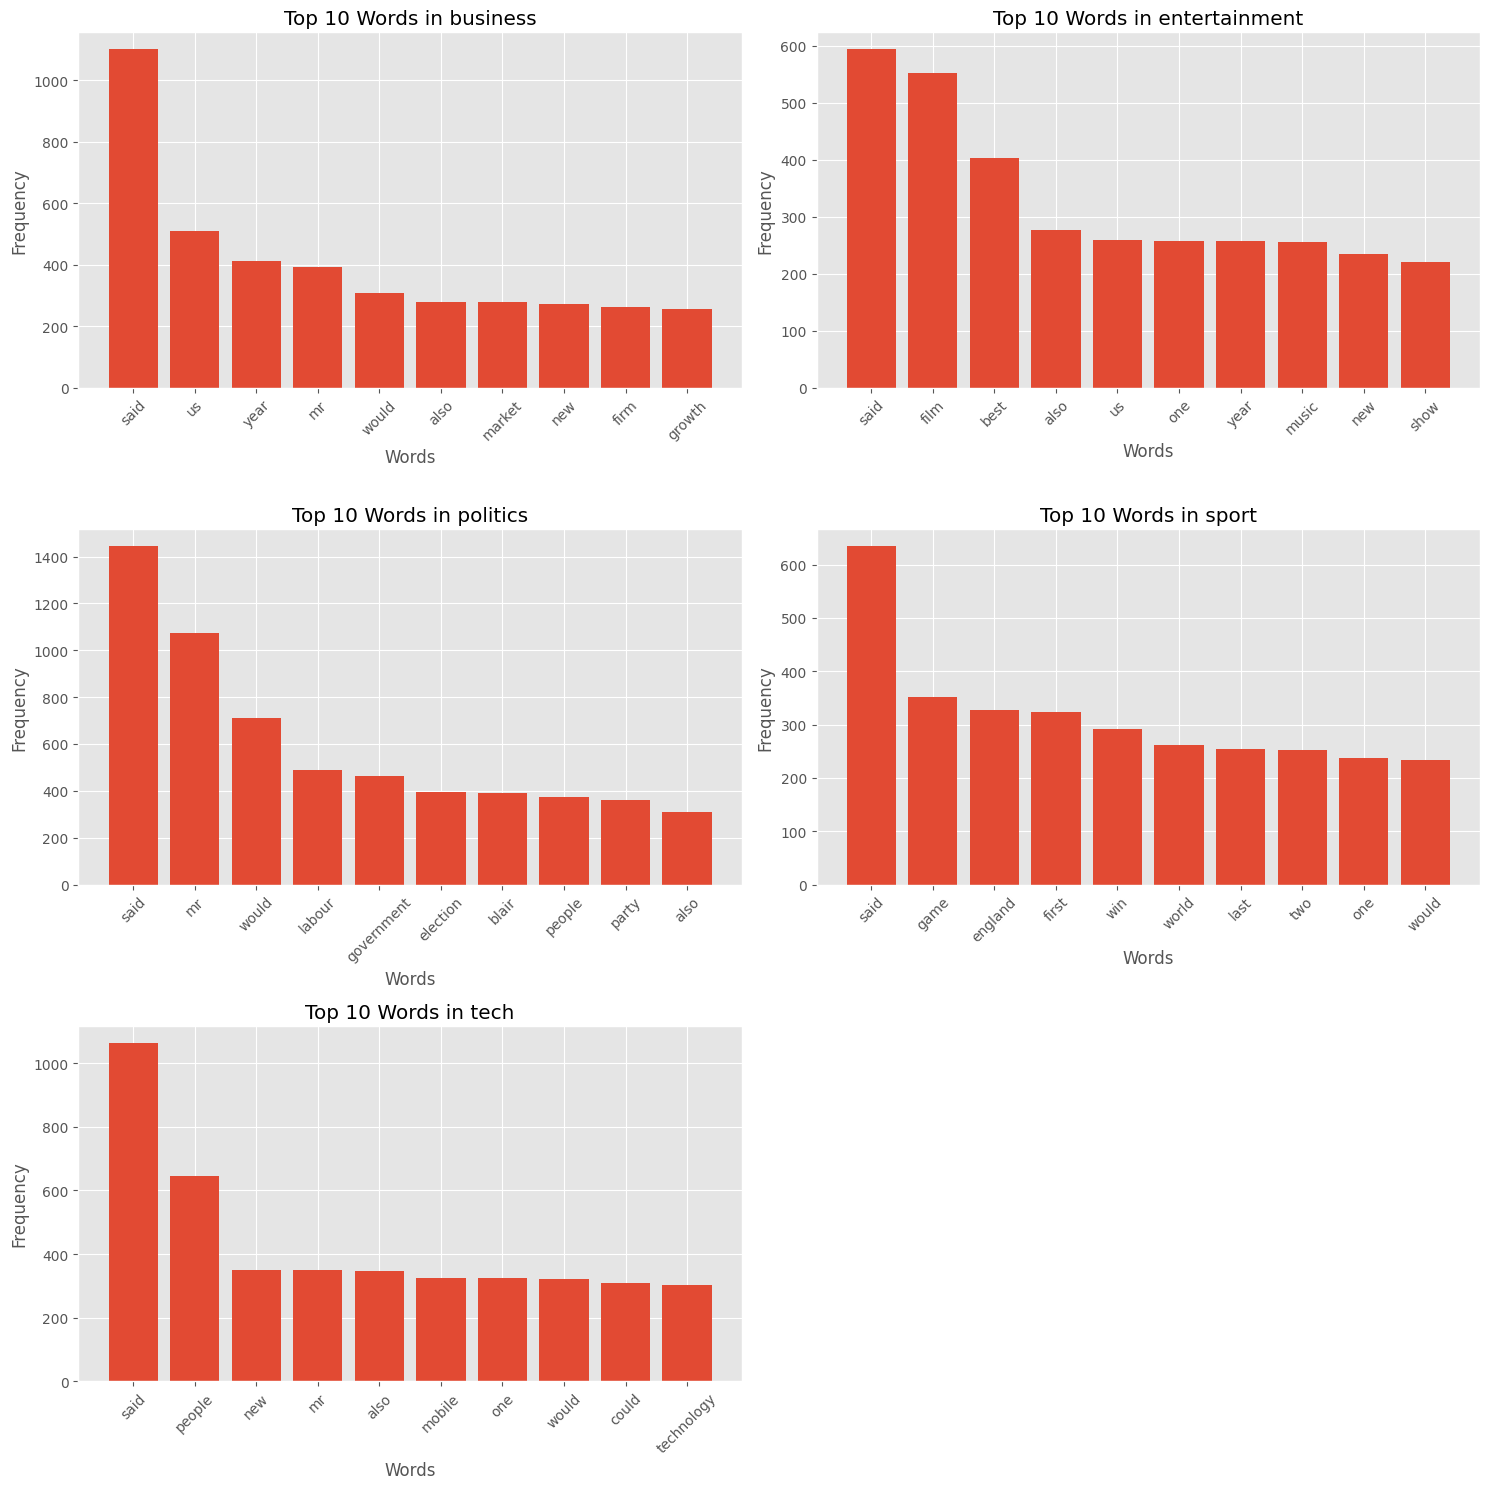

In [9]:
#Most common words by category
fig, axes = plt.subplots(3,2,figsize= (15,15))
axes = axes.flatten()

for ax, (cat,counts) in zip(axes, category_counts.items()):
    words,freq = zip(*counts)
    ax.bar(words, freq)
    ax.set_title(f'Top 10 Words in {cat}')
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation= 45)
# Remove last extra subplot
for i in range(len(category_counts),len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()


In [10]:
vocab

,Cetegory,Vocabary_size
0,business,10652
1,entertainment,10255
2,politics,9389
3,sport,9360
4,tech,10332


Higher numbers indicate larger vocabulary or more diverse word usage in that category.
Business has slightly more unique words than “politics” or “sport,” suggesting business articles may use a wider range of terminology.

## Topic Modeling 

Use topic modeling techniques such as Latent Dirichlet Allocation (LDA) to identify latent themes in the articles and check how well they align with the predefined categories. This may reveal overlapping topics across categories or expose hidden structures in the dataset.

In [11]:
#convert articles into words
vectorizer = CountVectorizer(max_df = 0.95, min_df =2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(train_df['Text'])


#Apply LDA with n_component=5 representing the number of categories in the dataset
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(doc_term_matrix)


#Show top words per topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [words[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: digital, games, use, technology, mr, music, new, mobile, people, said
Topic 2: england, new, game, brown, party, blair, election, labour, mr, said
Topic 3: market, new, deal, oil, shares, year, firm, company, mr, said
Topic 4: win, awards, time, new, won, world, year, said, best, film
Topic 5: world, economy, growth, new, people, mr, uk, government, year, said


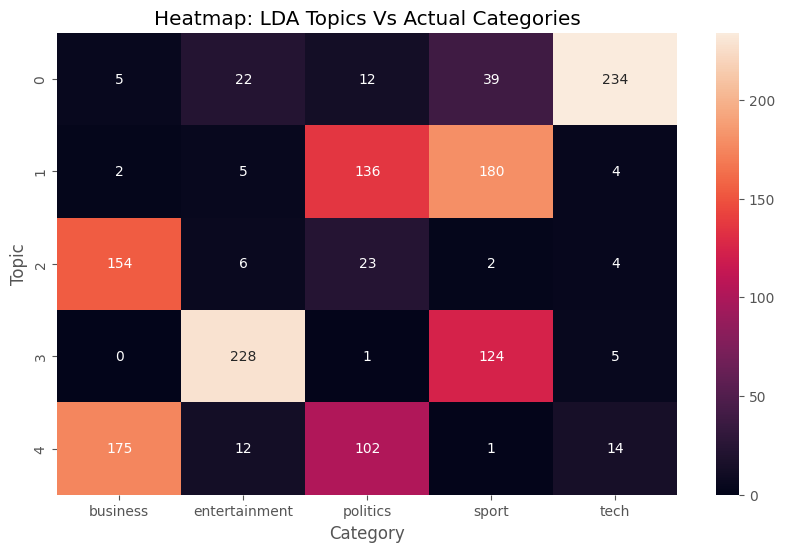

In [12]:
#create a heatmap showing how LDA topics align with actual categories.

#1. Get topic distributions for each document
topic_dist =  lda.transform(doc_term_matrix)

#2. Assign a dominant topic per document
train_df['dominat_topic'] = topic_dist.argmax(axis=1)

# 3. Create a cross-tab: topics vs categories
topic_category_matrix = pd.crosstab(train_df['dominat_topic'],train_df['Category'])

# 4. Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(topic_category_matrix, annot=True, fmt='d');
plt.title('Heatmap: LDA Topics Vs Actual Categories');
plt.xlabel('Category');
plt.ylabel('Topic');

### Key observations

1. **Topic 0: mostly tech**
   234 articles in tech, minor counts in sport/entertainment/business. Indicating a strong tech focus.
2. **Topic 1: politics + sport**
   136 politics, 180 sport. This topic overlaps politics and sports.
3. **Topic 2: mostly business**
   154 business articles, very few elsewhere, indicating strong alignment with business.
4. **Topic 3: entertainment + sport**
    228 entertainment, 124 sport overlaps, which could be likely entertainment-related sports (e.g., movies, awards, celebrity sports coverage).
5. **Topic 4:  business + politics**
   175 business, 102 politics, which could be topics about financial/political news overlapping themes.
### Conclusions
These results indicate that some topics are category-specific, while some topics overlap multiple categories.

# Model Building with Matrix Factorization

## TF-IDF + Single Value Decomposition (SVD) +LogisticRegression

In [13]:
Pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(random_state=42),
    LogisticRegression(max_iter=2000, random_state=42)
)

param_distributions = {
    'tfidfvectorizer__max_features': [5000, 10000, 15000],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__min_df': [2, 3, 5],
    'tfidfvectorizer__max_df': [0.85, 0.9, 0.95],
    'truncatedsvd__n_components': [100, 150, 200],
    'logisticregression__C': uniform(0.1, 10),
}

Random_search = RandomizedSearchCV(
    Pipeline,
    param_distributions=param_distributions,
    n_iter=20,          # number of random combinations to try
    scoring='accuracy',
    cv=5,               # 5-fold cross-validation
    verbose=0,
    n_jobs=-1,
    random_state=42
)

Random_search.fit(train_df['Text'], train_df['Category'])
best_params = Random_search.best_params_
print("Best parameters:", best_params)
print("Best CV accuracy:", Random_search.best_score_)


Best parameters: {'logisticregression__C': 8.761761457749351, 'tfidfvectorizer__max_df': 0.95, 'tfidfvectorizer__max_features': 10000, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2), 'truncatedsvd__n_components': 150}
Best CV accuracy: 0.9731543624161073


In [14]:
def display_report(model):
    """
    Parameters
    ----------
    model : sklearn estimator (Pipeline or compatible classifier)
        A trained model or pipeline that implements the `.predict()` method.
    
    train_df : pandas.DataFrame
        DataFrame containing at least two columns:
            - 'Text': str, input text features used for prediction.
            - 'Category': str or categorical, ground truth labels.

    Returns
    -------
    None
        Displays the classification report and shows a confusion matrix plot.

    """
    pred = model.predict(train_df['Text'])
    print(classification_report(train_df['Category'],pred))
    cm = confusion_matrix(train_df['Category'].astype(str),  pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=train_df['Category'].astype(str).unique())
    disp.plot(xticks_rotation=45,cmap='Blues')
    plt.show()

               precision    recall  f1-score   support

     business       0.99      0.98      0.98       336
entertainment       0.99      0.99      0.99       273
     politics       0.99      0.98      0.98       274
        sport       1.00      1.00      1.00       346
         tech       0.98      1.00      0.99       261

     accuracy                           0.99      1490
    macro avg       0.99      0.99      0.99      1490
 weighted avg       0.99      0.99      0.99      1490



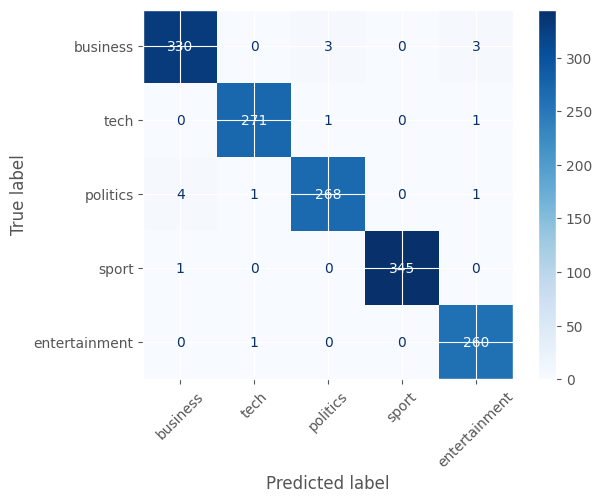

In [15]:
Pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words='english',
        max_features=best_params['tfidfvectorizer__max_features'],
        ngram_range=best_params['tfidfvectorizer__ngram_range'],
        min_df=best_params['tfidfvectorizer__min_df'],
        max_df=best_params['tfidfvectorizer__max_df']
    ),
    TruncatedSVD(
        n_components=best_params['truncatedsvd__n_components'],
        random_state=42
    ),
    LogisticRegression(
        max_iter=2000,
        C=best_params['logisticregression__C'],
        random_state=42
    )
)
    # TfidfVectorizer(stop_words='english', max_features=5000),
    # TruncatedSVD(n_components=100,random_state=0),
    # LogisticRegression(max_iter=1000)

Pipeline.fit(train_df['Text'], train_df['Category'])
display_report(Pipeline)


## TF-IDF + Non-Negative Matrix Factorization (NMF) + LogisticRegression

               precision    recall  f1-score   support

     business       0.81      0.84      0.83       336
entertainment       0.97      0.42      0.59       273
     politics       0.92      0.67      0.78       274
        sport       0.47      1.00      0.64       346
         tech       0.93      0.31      0.47       261

     accuracy                           0.68      1490
    macro avg       0.82      0.65      0.66      1490
 weighted avg       0.80      0.68      0.67      1490



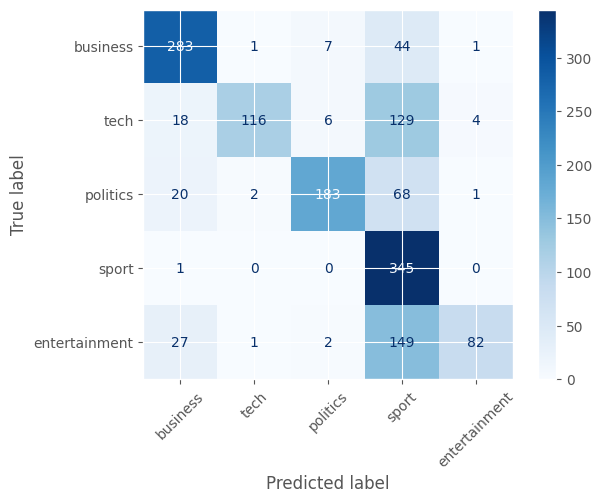

In [16]:
nmf = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=5000),
    NMF(n_components=100, random_state=0, init='nndsvda', max_iter=200),
    LogisticRegression(max_iter=1000)
)
nmf.fit(train_df['Text'], train_df['Category'])

#Model predict
# nmf_preds = nmf.predict(train_df['Text'])
# print(classification_report(train_df['Category'],nmf_preds))
display_report(nmf)
 

## TD-IDF + XGBOOSTClassifier

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       336
entertainment       1.00      1.00      1.00       273
     politics       1.00      1.00      1.00       274
        sport       1.00      1.00      1.00       346
         tech       1.00      1.00      1.00       261

     accuracy                           1.00      1490
    macro avg       1.00      1.00      1.00      1490
 weighted avg       1.00      1.00      1.00      1490



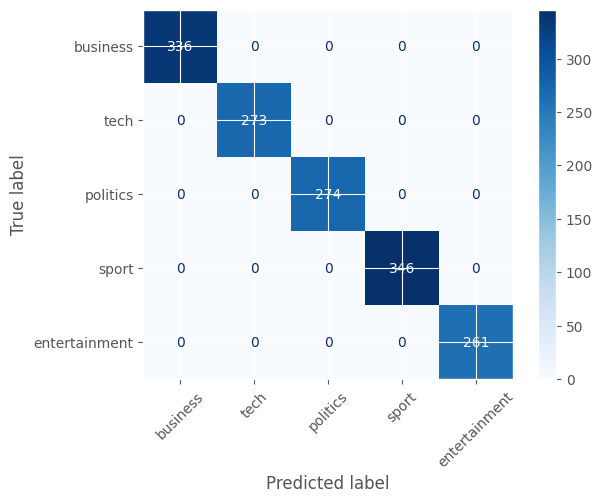

In [17]:
xgboost = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=5000),
    XGBClassifier(
        random_state=0, 
        max_depth=6,
        learning_rate=0.1,
        objective='multi:softmax', # multi-class classification
        eval_metric='mlogloss',
        use_label_encoder=False
    )
)
y_train = train_df['Category']
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# Fit pipeline on training data
xgboost.fit(train_df['Text'], y_train)

preds_numeric = xgboost.predict(train_df['Text'])

# Convert back to original category names
preds_labels = le.inverse_transform(preds_numeric)
print(classification_report(train_df['Category'], preds_labels))
cm = confusion_matrix(train_df['Category'].astype(str),  preds_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_df['Category'].astype(str).unique())
disp.plot(xticks_rotation=45,cmap='Blues')
plt.show()

In [18]:
preds_num = Pipeline.predict(test_df['Text'])
# xgb_preds_labels = le.inverse_transform(preds_num)
submission = pd.DataFrame({
    'ArticleId' : test_df['ArticleId'],
    'Category': preds_num
})
submission.to_csv('submission.csv', index=False)